# Домашнее задание по теме «Ансамблирование»

1. Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
2. Построить случайный лес, вывести важность признаков
3. Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
4. В качестве решения: Jupyter notebook с кодом, комментариями и графиками

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Функции

In [ ]:
# Для поиска выбросов будем использовать boxplot, pairplot
def get_boxplot(X, columns=None):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.boxplot(x=X[i])
    plt.show()
  pass  

def get_pairplot(X, columns=None):
  if columns is None:
    columns = X.columns

  sns.pairplot(X[columns])
  pass

def get_hist(X, columns=None, bins='auto'):
  if columns is None:
    columns = X.columns

  for i in columns:
    sns.histplot(x=X[i], bins=bins)
    plt.grid()
    plt.show()
  pass

def get_heatmap(X, columns=None):
  if columns is not None:
    X = X[columns]
    
  sns.heatmap(X.corr(), cmap='coolwarm', annot = True)
  pass

# По каждому признаку - число уникальных значений и тип
def get_stats(df, unic='all', limit=50):
  print('{0:<20} {1:>10} | {2:>10} | {3}\n'.format('Название колонки', 'Пустых', 'Уникальных', 'Тип данных')+'-'*57)
  for col in df.columns:
    print(f'{col:<20} {df[col].isnull().sum():>10} | {len(df[col].value_counts()):>10} | {df[col].dtype}')
  
  for col in df.columns:
    if len(df[col].value_counts())<limit+1:
      if unic=='object':
        if df[col].dtype=='object':
          print(f'\n{col}\n{"-"*57}')
          print(f'{df[col].value_counts()}\n{"-"*57}')
      else:
          print(f'\n{col}\n{"-"*57}')
          print(f'{df[col].value_counts()}\n{"-"*57}')          

  pass

# Решение

In [ ]:
# датасет
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Работаем с пропусками

In [ ]:
# количество пустых значений в каждом столбце
data.isnull().sum()[data.isnull().sum().values != 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [ ]:
#Находим категориальные признаки
cat_features = list(data.columns[data.dtypes == object])
int_features = list(set(data.columns) - set(cat_features))

In [ ]:
# заполняем пропуски, категориальные - новой категорией NaN, числовые - нулем
data[cat_features] = data[cat_features].fillna('NaN')
data[int_features] = data[int_features].fillna(0)

In [ ]:
data.isnull().sum()[data.isnull().sum().values != 0]

Series([], dtype: int64)

### Работа с переменными

Построим матрицу корреляции

In [ ]:
# отберем переменные, которые имеют больше чем 0,5 корреляцию с целевой переменной:
corr = data.corr()
feutures_05 = corr.index[abs(corr['SalePrice'])>0.5]

In [ ]:
corr[abs(corr['SalePrice'])>0.5]['SalePrice'].sort_values().index

Index(['YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath', '1stFlrSF',
       'TotalBsmtSF', 'GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual',
       'SalePrice'],
      dtype='object')

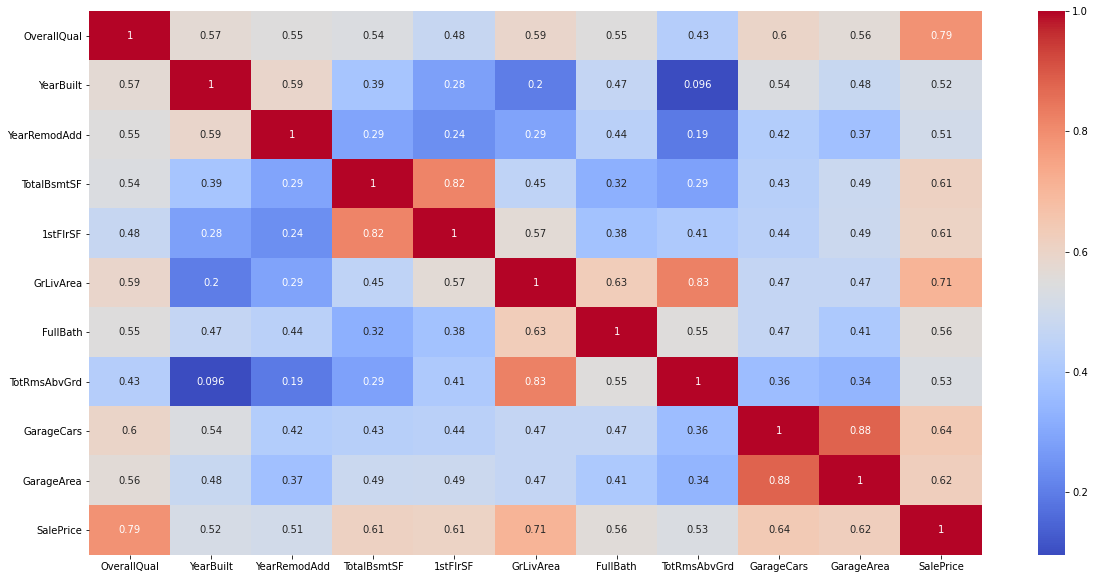

In [ ]:
# визуализируем матрицу
plt.figure(figsize=(20, 10))
get_heatmap(data[feutures_05])

Отрисуем графики попарной корреляции для самых важных переменных:

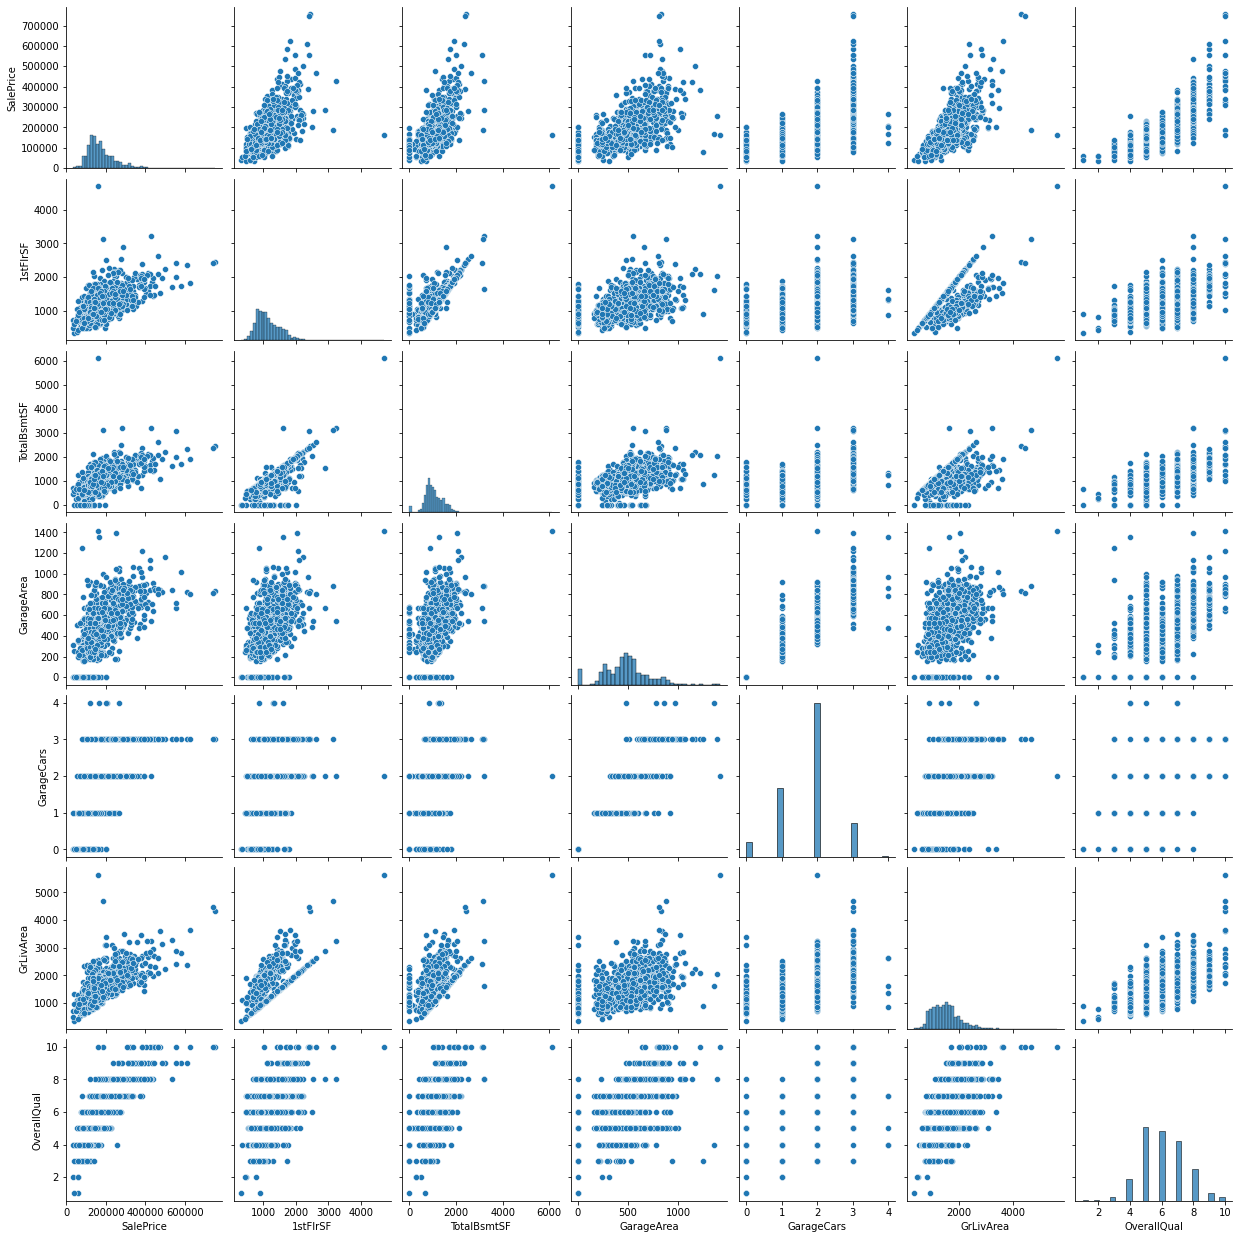

In [ ]:
get_pairplot(data[['SalePrice','1stFlrSF', 'TotalBsmtSF',
                   'GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual']])

Посмотрим на графики распределения следующих переменных:

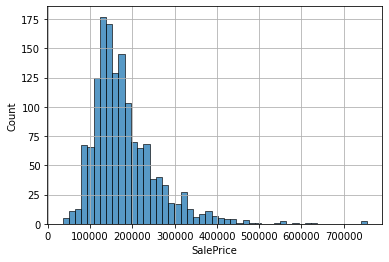

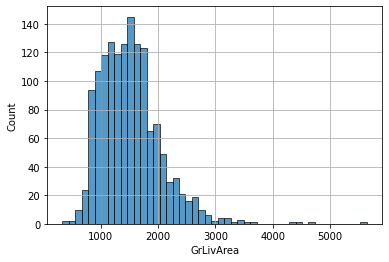

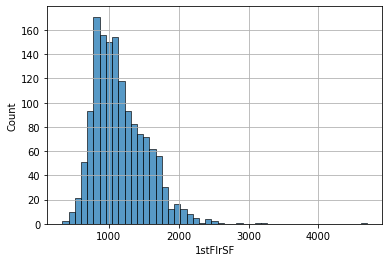

In [ ]:
get_hist(data, ['SalePrice'])
get_hist(data, ['GrLivArea'])
get_hist(data, ['1stFlrSF'])

Логарифмируем данные переменные и заметим, насколько исправленнее стало нормальное распределение:

In [ ]:
data['SalePrice'] = np.log1p(data['SalePrice'])
data['GrLivArea'] = np.log1p(data['GrLivArea'])
data['1stFlrSF'] = np.log1p(data['1stFlrSF'])

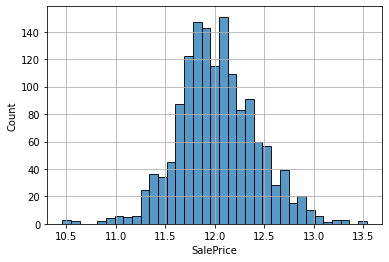

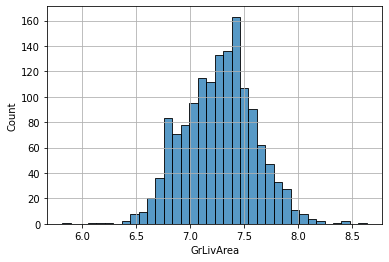

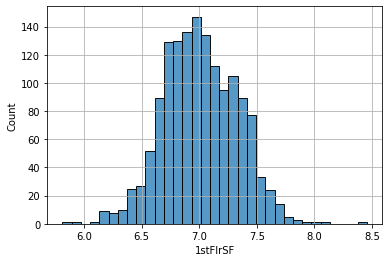

In [ ]:
get_hist(data, ['SalePrice'])
get_hist(data, ['GrLivArea'])
get_hist(data, ['1stFlrSF'])

Продолжим анализ, работаем с категориальными переменными:

In [ ]:
#Находим категориальные признаки
cat_features = list(data.columns[data.dtypes == object])
int_features = list(set(data.columns) - set(cat_features))

In [ ]:
# Обрабатываем категориальные переменные, если категорий немного - применяем OneHotEncoding
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

for i  in cat_features:
    if len(data[i].unique()) < 8:
        data = pd.get_dummies(data, columns=[i])
    else:
        le.fit(data[i])
        data[i] = le.transform(data[i])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 216 entries, Id to SaleCondition_Partial
dtypes: float64(6), int64(40), uint8(170)
memory usage: 767.2 KB


In [ ]:
data.head(3)

,Id,MSSubClass,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,...,GarageType_NaN,GarageFinish_Fin,GarageFinish_NaN,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NaN,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NaN,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_NaN,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NaN,MiscFeature_Gar2,MiscFeature_NaN,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,5,2,2,5,7,5,2003,2003,1,12,13,196.0,706,0,150,856,6.753438,854,0,7.444833,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,2,20,80.0,9600,24,1,2,2,6,8,1976,1976,1,8,8,0.0,978,0,284,1262,7.141245,0,0,7.141245,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
2,3,60,68.0,11250,5,2,2,5,7,5,2001,2002,1,12,13,162.0,486,0,434,920,6.825460,866,0,7.488294,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,...,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0


### Разбиение на train, test и нормирование

In [ ]:
# разбиваем данные на train и на test
y = data['SalePrice']
X = data.drop('SalePrice', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.3)  

In [ ]:
# делаем нормирование
from sklearn.preprocessing import StandardScaler
stX = StandardScaler()
X_train.loc[:,:] = stX.fit_transform(X_train)
X_test.loc[:,:] = stX.transform(X_test)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1022, 215), (1022,), (438, 215), (438,))

###  Случайный лес, важность признаков

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
clf = RandomForestRegressor(max_depth=10, n_estimators=200)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
# Оценка по RandomForestRegressor
from sklearn.metrics import mean_squared_error

# определяем функцию, вычисляющую корень из средквадратичного отклонения
def get_rmse(y_test, y_pred, log=None):
  if log:
    mse = mean_squared_error(np.log(y_test), np.log(y_pred))
  else:
    mse = mean_squared_error(y_test, y_pred)
  return np.sqrt(mse)

In [ ]:
get_rmse(y_test, y_pred)

0.13898563038642617

In [ ]:
# Выводим важность признаков
clf_feat = pd.Series(clf.feature_importances_, index=X_train.columns)
clf_feat.sort_values(ascending=False).head(10)

OverallQual    0.575209
GrLivArea      0.087795
GarageCars     0.049991
TotalBsmtSF    0.037359
GarageArea     0.024490
1stFlrSF       0.024382
BsmtFinSF1     0.015860
YearBuilt      0.012254
LotArea        0.012144
OverallCond    0.011352
dtype: float64

### Реализуем стекинг

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso, LinearRegression, ARDRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold

Линейной моделью будет Lasso, в стекинг также включим алгоритм случайного леса RandomForestRegressor и модель XGBRegressor.

Итоговым регрессором трех моделей будет модель ARDRegression (захотелось чего-то экзотического)

In [ ]:
# Список моделей
model_1 = Lasso()
model_2 = RandomForestRegressor()
#model_3 = XGBRegressor(colsample_bytree=1, gamma=0, max_depth=5, reg_alpha=0.6, reg_lambda=0.1,
#                                   subsample=0.9, n_jobs=-1, n_estimators=5000, learning_rate=0.01)
model_3 = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,learning_rate=0.05,
                       max_depth=3, min_child_weight=1.7817, n_estimators=2200,
                       reg_alpha=0.4640, reg_lambda=0.8571,subsample=0.5213,
                       random_state=7, nthread = -1)
final_model = ARDRegression()

In [ ]:
# Настраиваем стекинг-регрессор
regressor = StackingRegressor(
    [
     ('mod1', model_1),
     ('mod2', model_2),
     ('mod3', model_3)     
    ],
    final_model,
    cv=10)

In [ ]:
# обучение регрессора
regressor.fit(X_train, y_train)
regressor.final_estimator_

[09:25:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:26:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, threshold_lambda=10000.0, tol=0.001,
              verbose=False)

In [ ]:
# получаем предсказания целевой переменной по каждой из моделей
y_pred_1 = regressor.named_estimators_['mod1'].predict(X_test)
y_pred_2 = regressor.named_estimators_['mod2'].predict(X_test)
y_pred_3 = regressor.named_estimators_['mod3'].predict(X_test)

In [ ]:
# И результат регрессии по моделям
staking = regressor.predict(X_test)

In [ ]:
# среднеквадратическая ошибка каждой из модели
rmse_all = get_rmse(y_test,y_pred_1), get_rmse(y_test,y_pred_2), get_rmse(y_test,y_pred_3), get_rmse(y_test,staking)

Проиллюстрируем на графике размер ошибки каждой модели:

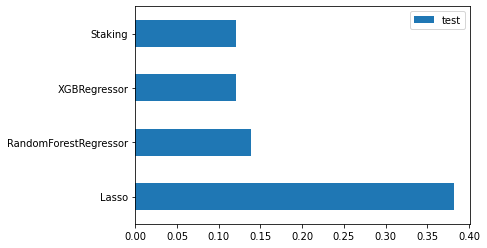

In [ ]:
pd.Series(list(rmse_all), index=['Lasso',
                                 'RandomForestRegressor',
                                 'XGBRegressor',
                                 'Staking']).plot(kind='barh', label='test')
plt.legend()
plt.show()

In [ ]:
rmse_all

(0.3822096081121143,
 0.1383906598814554,
 0.12072723977529762,
 0.12081953412065469)

Итак, результат стекинга по трем моделям:
- корень из среднеквадратической ошибки: 0.12081953412065469

In [ ]:
import pickle
pickle.dump(regressor, open('regressor.pkl', 'wb'),protocol=4)